In [1]:
import cv2
import numpy as np
import torch
import os

from PIL import Image
from uuid import uuid4

In [8]:
WHOLE_MODEL_PATH = './unet_res18_whole.pth'
IMAGE_SIZE = (480, 320)
MASK_TRESHOLD = 0.97

In [3]:
model = torch.load(WHOLE_MODEL_PATH, map_location=torch.device('cpu'))

In [4]:
class Scaler(object):
    def __init__(self, size, grayscale=False):
        self._size = size
        self._grayscale = grayscale
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = self._grayscale
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        # TODO: фикс индексирования для маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        return result

In [25]:
def load_scale_image(img_name, image_size=IMAGE_SIZE):
    image = Image.open(img_name)
    image = np.asarray(image) / 255.
    scaler = Scaler(image_size)
    image = scaler(image)
    image = image_to_torch(image).float()        
    return image

In [6]:
def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    
    if image.shape[-1] == 4:
        image = image[..., :3]
    
    result = torch.from_numpy(np.ascontiguousarray(image))
    
    if device is not None:
        result = result.to(device)
    
    result = result.permute(2, 0, 1)
    return result

In [7]:
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image

    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()

In [27]:
def mask_from_prediction(predicted, treshold):
    predicted = (predicted > treshold).float()
    return torch.cat((torch.zeros_like(predicted[0]).unsqueeze(0), predicted), dim=0)

def save_image_and_mask(image, predicted, treshold, img_dir):
    c = predicted.shape[0]
    
    if c == 1:
        predicted = torch.nn.functional.logsigmoid(predicted)
        predicted_labels = predicted[0] > np.log(0.5)
    else:
        predicted = torch.sigmoid(predicted)
        predicted = mask_from_prediction(predicted, treshold)
        predicted_labels = (predicted * 255).permute(1, 2, 0)

    predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
    image = image_to_numpy(image)

    image_pred = Image.fromarray(predicted_labels)
    display(Image.fromarray(image))
    display(image_pred)
    image_pred_path = os.path.join(img_dir, "segmented-" + str(uuid4()) + ".png")
    image_pred.save(image_pred_path)
    return image_pred_path

def get_pred(model, img_path, img_dir):
    image = load_scale_image(img_path)
    
    with torch.no_grad():   
        predicted = model(image.unsqueeze(0))[0]  # CHW.              
        image_pred_path = save_image_and_mask(image, predicted, MASK_TRESHOLD, img_dir)
        return predicted, image_pred_path

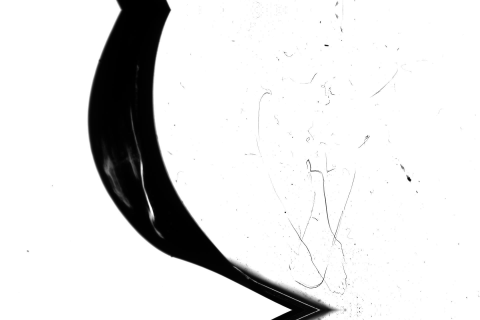

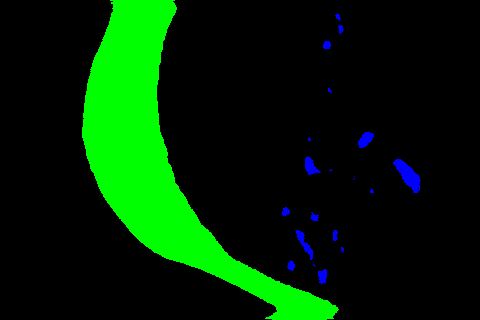

In [28]:
predicted, image_pred_path = get_pred(model, "01.png", ".")

In [29]:
import json

def torch_to_json(tensor):
    return json.dumps(tensor.numpy().tolist())

def json_to_torch(data):
    return torch.tensor(np.array(json.loads(data)))

data = torch_to_json(predicted)
torch.all(json_to_torch(data) == predicted)

tensor(True)

In [30]:
image_pred_path

'./segmented-a80bfe52-24b2-4967-8947-3d83bc059c42.png'

In [31]:
with open("predicted.json", "w") as f:
    f.write(data)

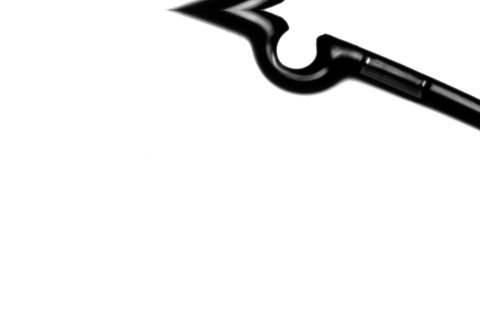

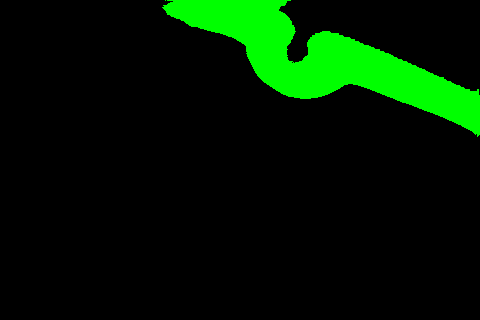

In [32]:
predicted, image_pred_path = get_pred(model, "0/344.jpg", ".")

In [33]:
with open("predicted_0.json", "w") as f:
    f.write(torch_to_json(predicted))